In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

2024-05-30 07:53:43.816515: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 07:53:43.816623: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 07:53:43.816662: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 07:53:43.825619: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('dataset/features/time_1.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12658 entries, 0 to 12657
Data columns (total 46 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         12658 non-null  int64  
 1   mean_A_F  12658 non-null  float64
 2   var_A_F   12658 non-null  float64
 3   std_A_F   12658 non-null  float64
 4   rms_A_F   12658 non-null  float64
 5   mav_A_F   12658 non-null  float64
 6   mean_A_V  12658 non-null  float64
 7   var_A_V   12658 non-null  float64
 8   std_A_V   12658 non-null  float64
 9   rms_A_V   12658 non-null  float64
 10  mav_A_V   12658 non-null  float64
 11  mean_A_L  12658 non-null  float64
 12  var_A_L   12658 non-null  float64
 13  std_A_L   12658 non-null  float64
 14  rms_A_L   12658 non-null  float64
 15  mav_A_L   12658 non-null  float64
 16  mean_L_F  12658 non-null  float64
 17  var_L_F   12658 non-null  float64
 18  std_L_F   12658 non-null  float64
 19  rms_L_F   12658 non-null  float64
 20  mav_L_F   12658 non-null  fl

In [4]:
df.shape

(12658, 46)

In [5]:
df['0'].value_counts()

0    10804
1     1617
2      237
Name: 0, dtype: int64

In [6]:
# status 열에서 값이 0인 행 제거
df = df[df['0'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['0'] = df['0'].replace({1: 0, 2: 1})

In [7]:
df['0'].value_counts()

0    1617
1     237
Name: 0, dtype: int64

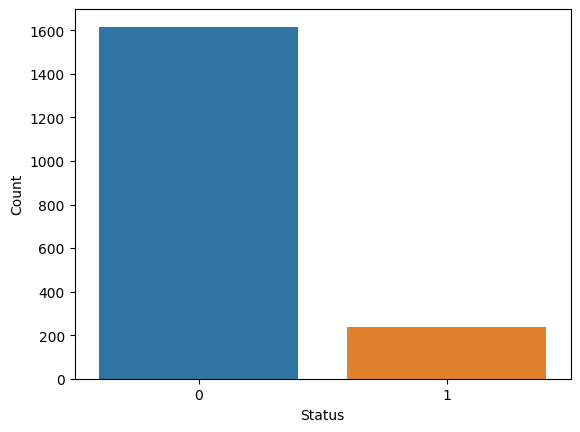

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['0'] = df['0'].astype('category')

# Now plot
sns.countplot(data=df, x="0")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

In [9]:
def split_sequence(X, y, n_steps):
    X_seq, y_seq = list(), list()
    for i in range(len(X) - n_steps + 1):
        end_ix = i + n_steps
        seq_x = X[i:end_ix]
        seq_y = y[end_ix-1]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

In [10]:
X = df.drop(columns=['0']).to_numpy()
y = df['0'].to_numpy()

In [11]:
n_steps = 3

In [12]:
X, y = split_sequence(X, y, n_steps)

In [13]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [14]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1184, 3, 45), (371, 3, 45), (1184, 2), (371, 2))

In [17]:
n_features, n_outputs = X_train.shape[1], y_train.shape[1]

In [18]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            89088     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             24640     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 2)                 1

In [19]:
epochs, batch_size = 50, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/50
19/19 [==============================] - 2s 27ms/step - loss: 0.4416 - accuracy: 0.8446 - val_loss: 0.3681 - val_accuracy: 0.8721
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3915 - accuracy: 0.8716 - val_loss: 0.3875 - val_accuracy: 0.8721
Epoch 3/50
19/19 [==============================] - 0s 8ms/step - loss: 0.3815 - accuracy: 0.8708 - val_loss: 0.3744 - val_accuracy: 0.8721
Epoch 4/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3892 - accuracy: 0.8716 - val_loss: 0.3828 - val_accuracy: 0.8721
Epoch 5/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3648 - accuracy: 0.8716 - val_loss: 0.3846 - val_accuracy: 0.8721
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3777 - accuracy: 0.8716 - val_loss: 0.3827 - val_accuracy: 0.8721
Epoch 7/50
19/19 [==============================] - 0s 7ms/step - loss: 0.3626 - accuracy: 0.8725 - val_loss: 0.3860 - val_accuracy: 0.8721
Epoch 8/50
19/19 [=

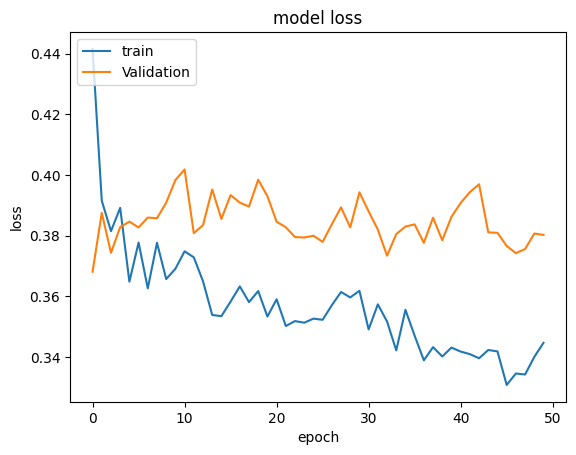

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

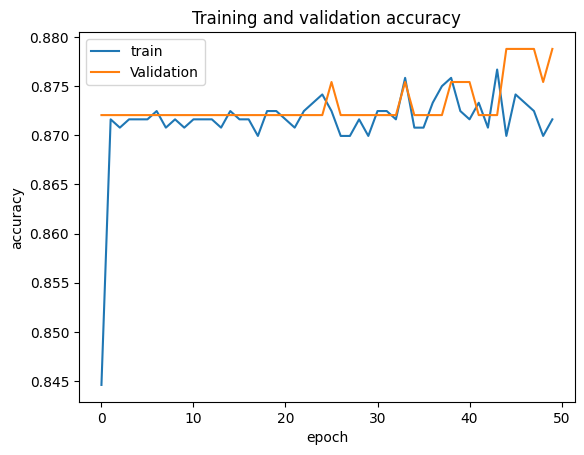

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

12/12 [==============================] - 0s 2ms/step
f1_score =  0.8115657926978681
0.8679245283018868
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       324
           1       0.00      0.00      0.00        47

    accuracy                           0.87       371
   macro avg       0.44      0.50      0.46       371
weighted avg       0.76      0.87      0.81       371



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

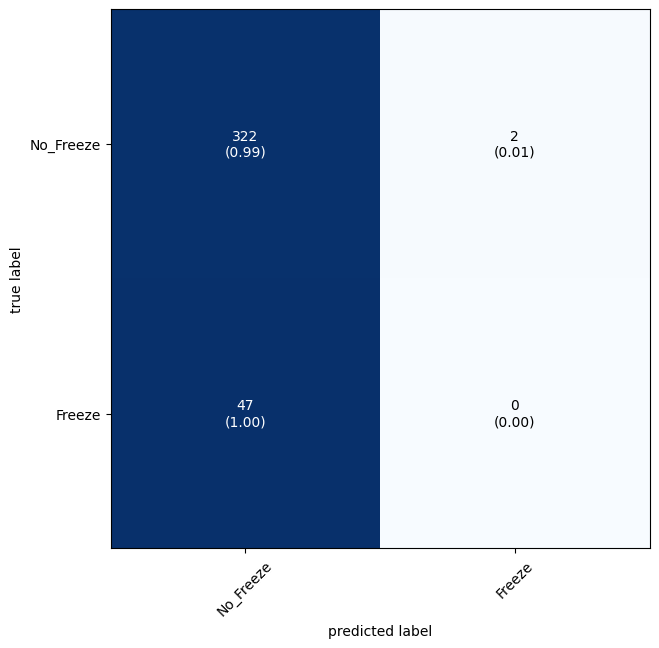

In [22]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))

### SMOTE() 오버 샘플링

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop('0', axis=1), df['0'])

In [24]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('0', axis=1).columns),
                         pd.DataFrame({'0': y_resampled})], axis=1)

In [25]:
print(df['0'].value_counts())

0    1617
1    1617
Name: 0, dtype: int64


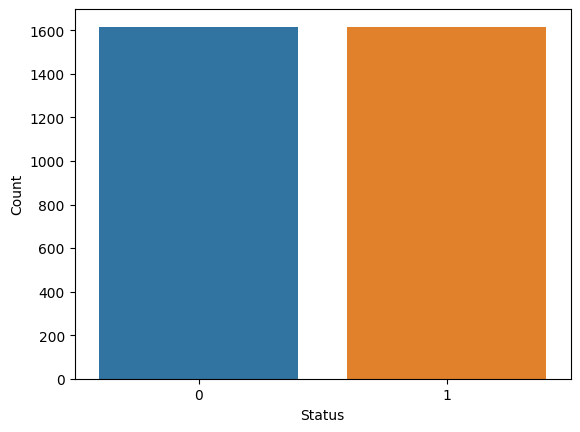

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and '0' is the column name
# Ensure the column is of categorical dtype
df['0'] = df['0'].astype('category')

# Now plot
sns.countplot(data=df, x="0")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

In [27]:
X = df.drop(columns=['0']).to_numpy()
y = df['0'].to_numpy()

In [28]:
X, y = split_sequence(X, y, n_steps)

In [29]:
Y = to_categorical(y)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [30]:
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = y)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size = 0.2, random_state = 0, stratify = y_train)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2068, 3, 45), (647, 3, 45), (2068, 2), (647, 2))

In [33]:
n_features, n_outputs = X_train.shape[1], y_train.shape[1]

In [34]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3, 128)            89088     
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             24640     
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 2)                

In [35]:
epochs, batch_size = 50, 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/50
33/33 [==============================] - 2s 18ms/step - loss: 0.7048 - accuracy: 0.5348 - val_loss: 0.6610 - val_accuracy: 0.6151
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6695 - accuracy: 0.5822 - val_loss: 0.6432 - val_accuracy: 0.6402
Epoch 3/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6669 - accuracy: 0.5938 - val_loss: 0.6337 - val_accuracy: 0.6441
Epoch 4/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6497 - accuracy: 0.6161 - val_loss: 0.6271 - val_accuracy: 0.6383
Epoch 5/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6532 - accuracy: 0.6320 - val_loss: 0.6212 - val_accuracy: 0.6673
Epoch 6/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6409 - accuracy: 0.6320 - val_loss: 0.6163 - val_accuracy: 0.6499
Epoch 7/50
33/33 [==============================] - 0s 7ms/step - loss: 0.6421 - accuracy: 0.6228 - val_loss: 0.6110 - val_accuracy: 0.6712
Epoch 8/50
33/33 [=

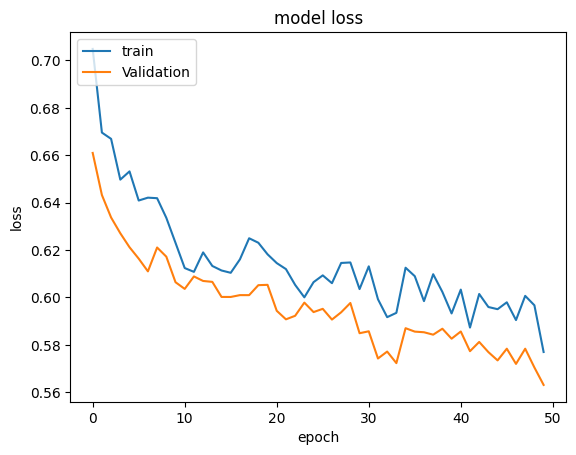

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

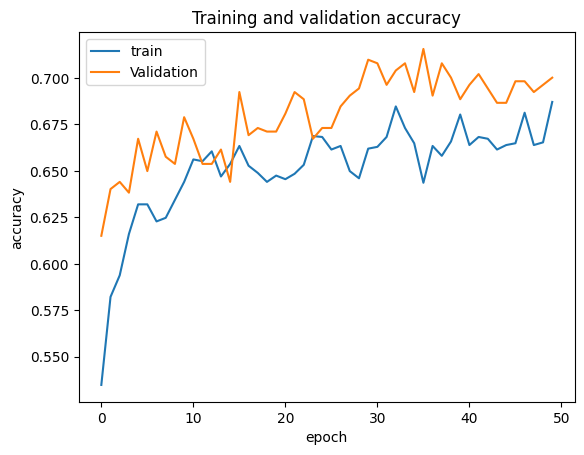

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

21/21 [==============================] - 0s 2ms/step
f1_score =  0.716782618246592
0.7171561051004637
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       323
           1       0.70      0.75      0.73       324

    accuracy                           0.72       647
   macro avg       0.72      0.72      0.72       647
weighted avg       0.72      0.72      0.72       647



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

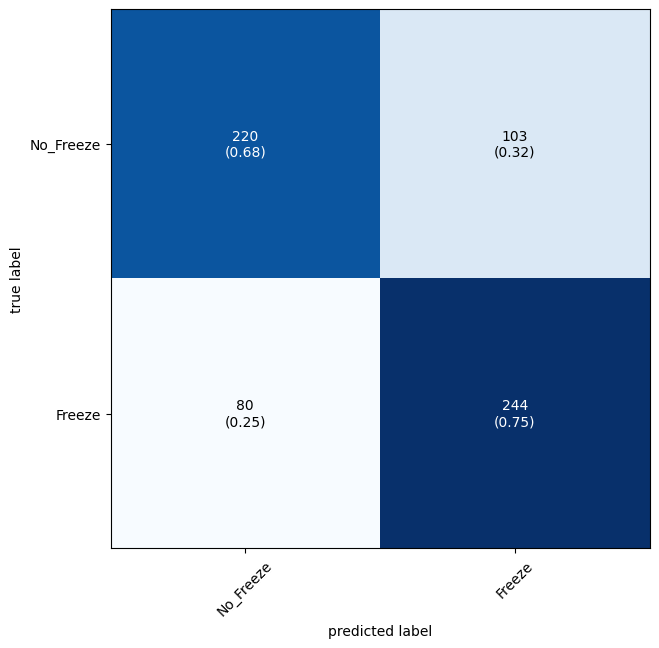

In [38]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np

# 모델 예측
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
y_true = np.argmax(y_test, axis=-1)

LABELS = ['No_Freeze', 'Freeze']
cm = confusion_matrix(y_true, predy)

# 결과 출력
print('f1_score = ', f1_score(y_true, predy, average='weighted'))
print(accuracy_score(y_true, predy))
print(classification_report(y_true, predy))

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7, 7))